# Сети Кохонена
Целью работы является исследование свойств слоя Кохонена, карты Кохонена, а также сетей векторного квантования, обучаемых с учителем, алгоритмов обучения, а также применение сетей в задачах кластеризации и классификации
## Основные этапы работы:
1. Использовать слой Кохонена для выполнения кластеризации множества точек. Проверить качество разбиения
2. Использовать карту Кохонена для выполнения кластеризации множества точек.
3. Использовать карту Кохонена для нахождения одного из решений задачи коммивояжера
4. Использовать сеть векторного квантования, обучаемую с учителем, (LVQ-сеть) для клас- сификации точек в случае, когда классы не являются линейно разделимыми.

In [1]:
import numpy as np
import neurolab as nl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import make_blobs
from minisom import MiniSom
from matplotlib.patches import RegularPolygon
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neupy.algorithms import LVQ

In [2]:
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'lime', 'orange'] 

In [3]:
def gen_points(points, clusters, random_state=43):
    """
    Генерация кластеров точек
    :param points: Количество точек в кластере
    :param clusters: Количество кластеров
    """
    x, y, c = make_blobs(
        n_samples=points*clusters,
        centers=clusters,
        n_features=2,
        cluster_std=0.1,
        center_box=(0, 1.5),
        return_centers=True,
        random_state=random_state
    )
    plt.figure(figsize=(14, 9))
    for i in range(clusters):
        plt.scatter(x[y==i, 0], x[y==i, 1], c=colors[i])
    plt.plot(c[:,0], c[:, 1], 'dk')
    plt.grid(True)
    return x, y, c

In [4]:
def gen_points_path():
    z = np.array([[
        np.random.uniform(-1.5, 1.5),
        np.random.uniform(-1.5, 1.5)] for _ in range(20)])

    plt.figure(figsize=(14, 9))
    plt.plot(z[:, 0], z[:, 1])
    plt.scatter(z[:, 0], z[:, 1], c='red')
    plt.grid(True)
    plt.show()
    return z

In [5]:
def find_path(z):
    np.random.RandomState(10)
    neurons = 20

    som = MiniSom(1, neurons, z.shape[1], sigma=8, learning_rate=0.4,
                  neighborhood_function='gaussian', random_seed=0)
    som.random_weights_init(z)

    plt.figure(figsize=(14, 9))
    for i, iterations in enumerate(range(100, 301, 100)):
        som.train(z, iterations, verbose=False, random_order=False)
        plt.subplot(3, 4, i+1)
        plt.scatter(z[:, 0], z[:, 1], c='red')
        visit_order = np.argsort([som.winner(p)[1] for p in z])
        plt.plot(z[visit_order][:,0], z[visit_order][:,1])
        plt.title("Epochs: {i};\nError: {e:.3f}".format(i=iterations, e=som.quantization_error(z)))
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [6]:
class KohonenNet:

    def __init__(self, clusters):
        self.net =  nl.net.newc(([0, 1], [0, 1]), clusters)

    def train(self, x, epochs=150, show=15):
        error = self.net.train(x, epochs=epochs, show=show)
        plt.figure(figsize=(14, 9))
        plt.title('Ошибка обучения')
        plt.plot(error)
        plt.grid()
        plt.xlabel('Кол-во эпох')
        plt.ylabel('MAE')
        plt.show()

        w = self.net.layers[0].np['w']
        plt.figure(figsize=(14, 9))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap='Set2')
        plt.scatter(c[:,0], c[:, 1], s = 80, marker='^', label="Target centers")
        plt.scatter(w[:,0], w[:,1], s = 80, marker='s', label="Train centers")
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict_random_points(self, n, c, y):
        points = np.array([
            [np.random.uniform(0, 1.5), np.random.uniform(0, 1.5)] for _ in range(n)
        ])
        predicts = self.net.sim(points)
        clusters = np.argmax(predicts, axis=1)
        w = self.net.layers[0].np['w']

        plt.figure(figsize=(14, 9))
        plt.scatter(w[:,0], w[:, 1], s = 100, marker='^', c=colors, label="Target centers")
        for i in range(8):
            plt.scatter(points[clusters==i, 0], points[clusters==i, 1], c=colors[i], s=70, marker='*')
        plt.grid(True)
        plt.legend()
        plt.show()

In [7]:
class SelfOrganizedMap:

    def __init__(self, points_num):
        self.som = MiniSom(
            x=2,
            y=4,
            input_len=points_num,
            sigma=0.9, # initial spread
            learning_rate=0.7,
            activation_distance='euclidean',
            topology='hexagonal',
            neighborhood_function='gaussian',
            random_seed=10
        )

    def train(self, x, y):
        err = self.som.train(x, 150, verbose=True)
        pred_cntrs = self.som.get_weights()
        plt.figure(figsize=(14, 9))
        for i in range(8):
            plt.scatter(x[y==i,0], x[y==i,1], c=colors[i])
        plt.scatter(pred_cntrs[0][:,0], pred_cntrs[0][:, 1], s = 100, marker='s', label='w0')
        plt.scatter(pred_cntrs[1][:,0], pred_cntrs[1][:, 1], s = 100, marker='s', label='w1')
        plt.legend()
        plt.grid(True)
        plt.show()

    def predict_random_points(self, n, x, y, c):
        points = np.array([
            [np.random.uniform(0, 1.5), np.random.uniform(0, 1.5)] for _ in range(n)
        ])
        pred_cntrs = self.som.get_weights()
        c = np.reshape(pred_cntrs,(8,2))
        plt.figure(figsize=(14, 9))
        plt.scatter(c[:,0], c[:, 1], s = 100, c = colors, marker='s', label="predict centers")

        winner_coordinates = np.array([self.som.winner(p) for p in points]).T
        cluster_index = np.ravel_multi_index(winner_coordinates, (2,4))
        print(cluster_index)
        for i in range(8):
            plt.scatter(points[cluster_index==i, 0], points[cluster_index == i, 1], c=colors[i], s=70, marker='*')

        plt.grid(True)
        plt.legend()
        plt.show()

In [24]:
def gen_lvq_points():
    points = np.array([
        [-1.3, -0.8, -0.7, 1.4, 0.6, 0.5, -0.4, -0.5, -0.4, 0, -0.9, 0.2 ],
        [0.6, -0.4, 0.9, 0.4, 1.2, 0.2, 0.4, -0.3, -0.1, 1.2, -0.5, -0.1]
    ])
    target = np.array([1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1])
    clrs = ['blue' if l else 'red' for l in target]
    plt.scatter(points.T[:, 0], points.T[:, 1], c=clrs)
    plt.grid(True)
    plt.show()
    return points, target


def lvq_train(points, target):
    lvq = LVQ(n_inputs=2, n_classes=2, n_subclasses=3, step=0.1)
    lvq.train(points.T, target, epochs=300)
    h = 0.1
    colors = []
    d1 = np.array([])
    d2 = np.array([])
    I = np.linspace(-1.5,1.5,num=10)
    J = np.linspace(-1.5,1.5,num=10)
    for i in I:
        for j in J:
            d1 = np.append(d1,i)
            d2 = np.append(d2,j)
            pr = lvq.predict(np.array([i,j], ndmin=2))
            if pr == 0:
                colors.append('red')
            else:
                colors.append('blue')

    d = np.column_stack((d1, d2))
    plt.scatter(d[:,0], d[:,1], c=colors)
    plt.scatter(points.T[:, 0], points.T[:, 1], c=clrs)
    plt.show()

## Задание 1
### Cлой Кохонена для выполнения кластеризации множества точек. Проверить качество разбиения

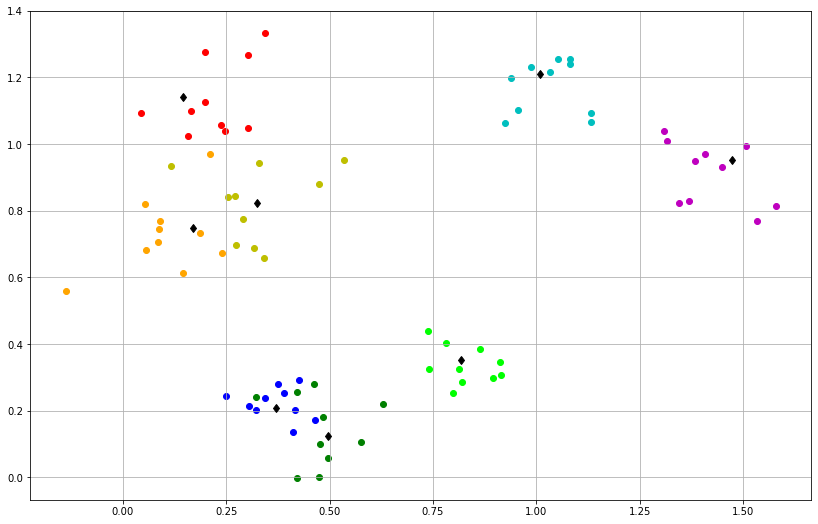

In [8]:
x, y, c = gen_points(10, 8, random_state=19)

Epoch: 15; Error: 19.648550723982407;
Epoch: 30; Error: 19.23765026268773;
Epoch: 45; Error: 18.66555239836071;
Epoch: 60; Error: 17.947817680840423;
Epoch: 75; Error: 17.35379593911876;
Epoch: 90; Error: 16.740187753189705;
Epoch: 105; Error: 15.785878054209983;
Epoch: 120; Error: 15.154769273897363;
Epoch: 135; Error: 14.207804552789385;
Epoch: 150; Error: 13.30570260049247;
The maximum number of train epochs is reached


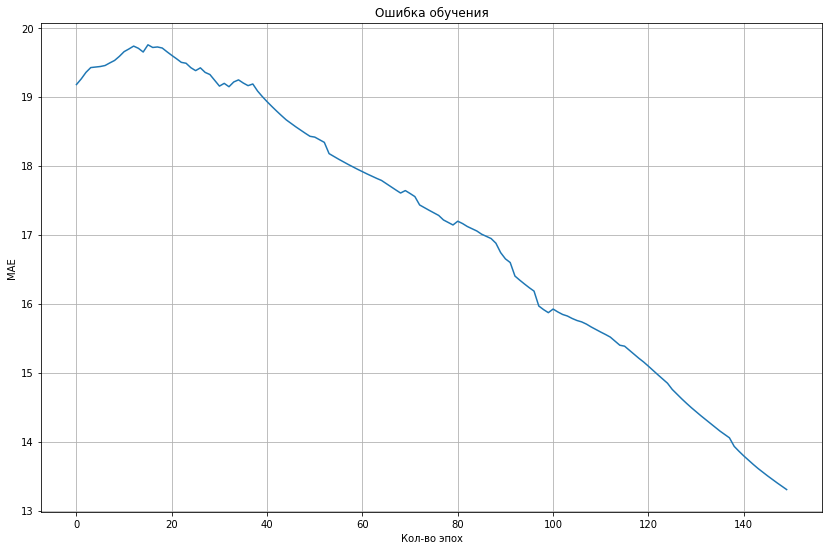

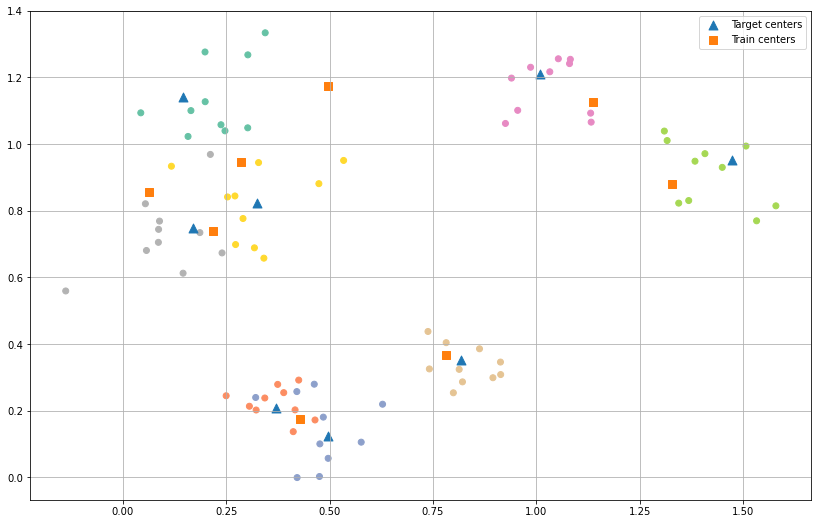

In [9]:
kohonen_net = KohonenNet(clusters=8)
kohonen_net.train(x)

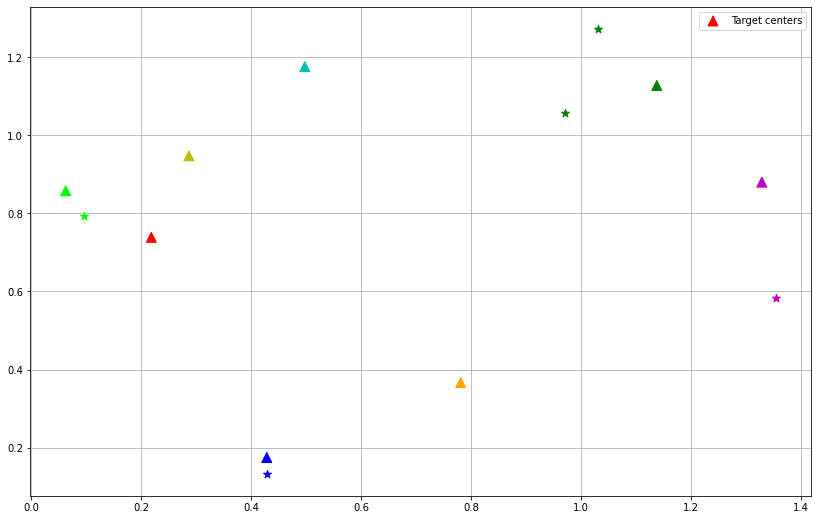

In [10]:
kohonen_net.predict_random_points(5, c, y)

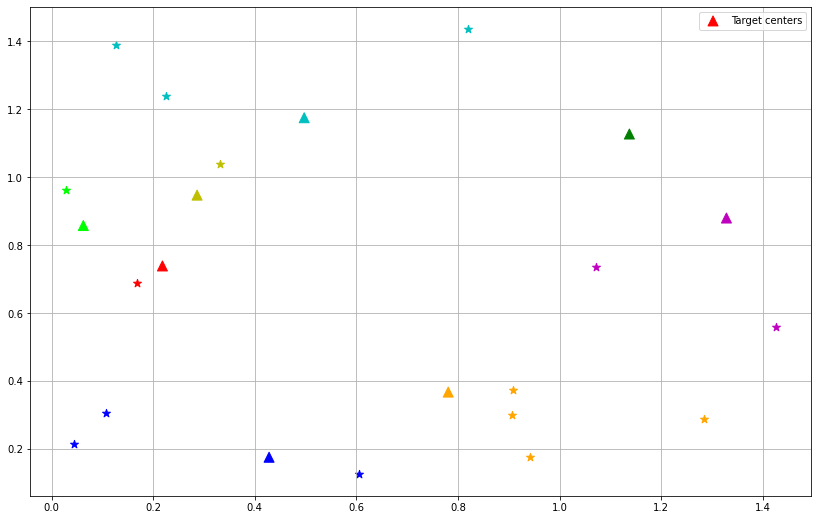

In [11]:
kohonen_net.predict_random_points(15, c, y)

## Задание 2
### Использовать карту Кохонена 2 на 4 для выполнения кластеризации множества точек.

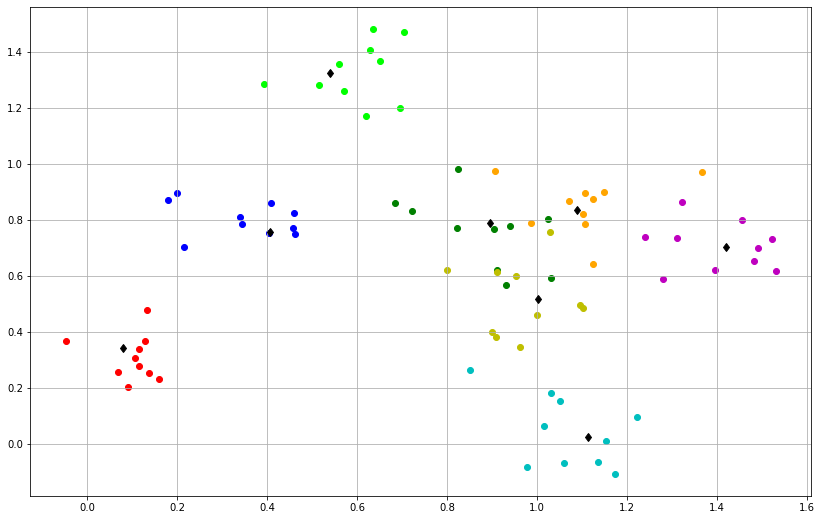

In [12]:
x, y, c = gen_points(10, 8, random_state=170)

 [ 150 / 150 ] 100% - 0:00:00 left 
 quantization error: 0.11926387387276993


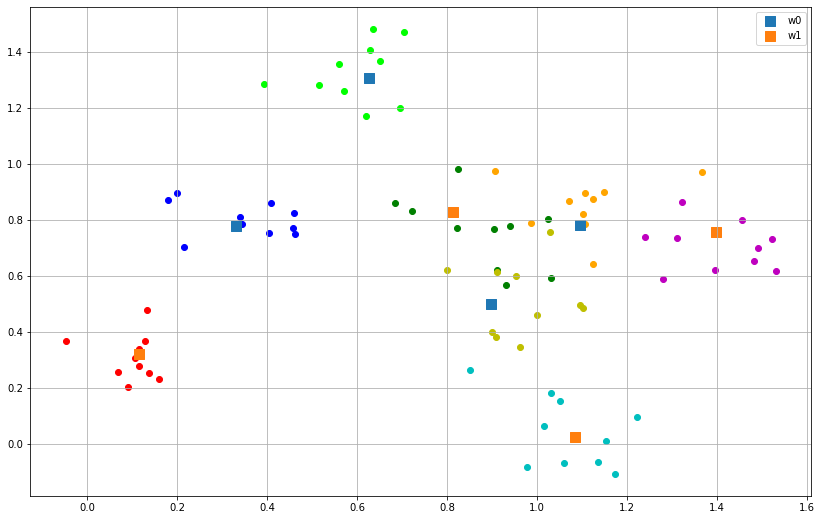

In [13]:
som = SelfOrganizedMap(2)
som.train(x, y)

[2 2 0 2 6]


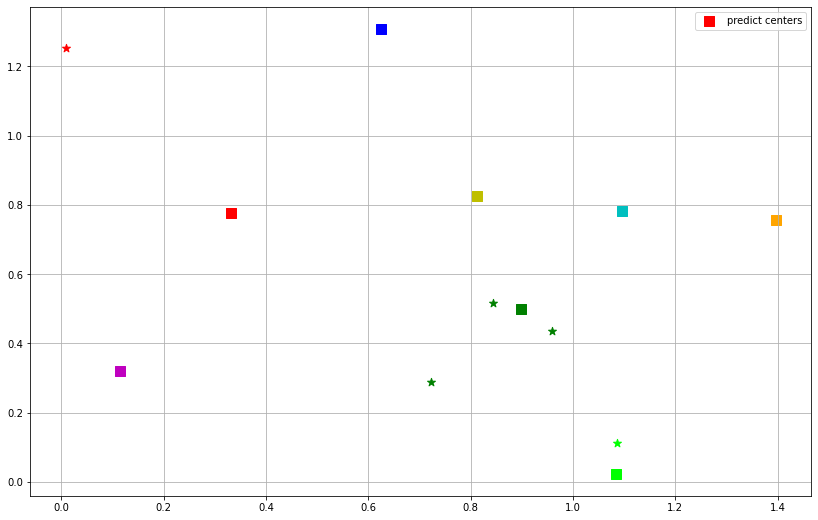

In [14]:
som.predict_random_points(5, x, y, c)

[3 3 2 4 4 0 6 3 7 0 6 2 1 2 0]


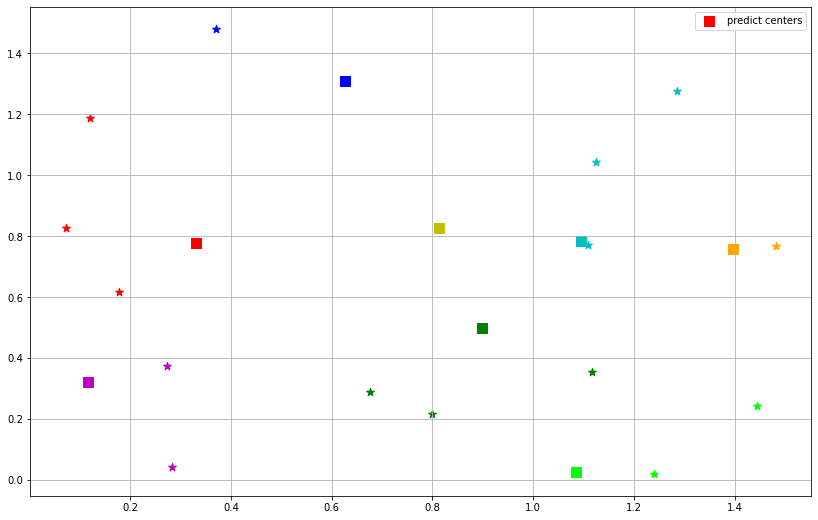

In [15]:
som.predict_random_points(15, x, y, c)

## Задание №3
Использовать карту Кохонена для нахождения одного из решений задачи коммивояжера

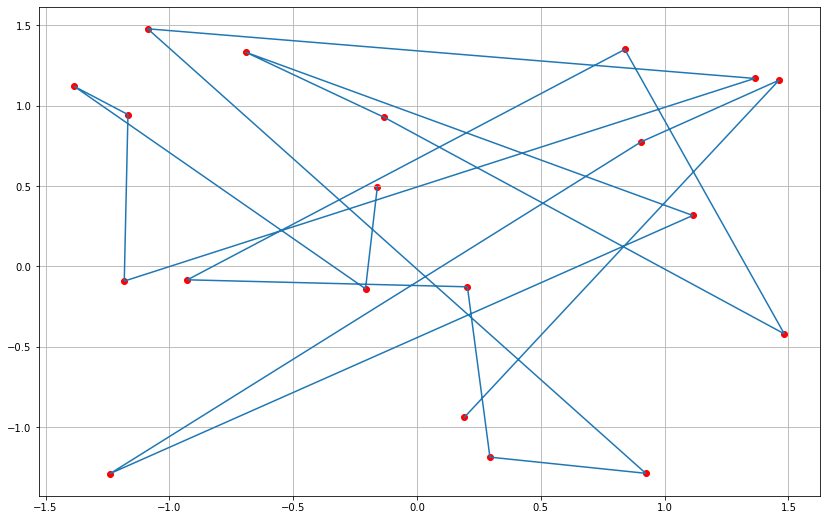

In [16]:
points = gen_points_path()

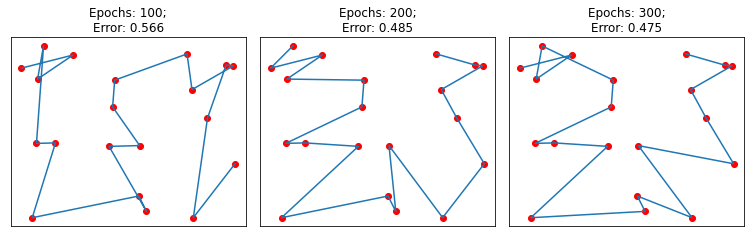

In [17]:
find_path(points)

# Задание №4
Использовать сеть векторного квантования, обучаемую с учителем (LVQ-сеть), для классификации точек в случае, когда классы не являются линейно разделимыми.

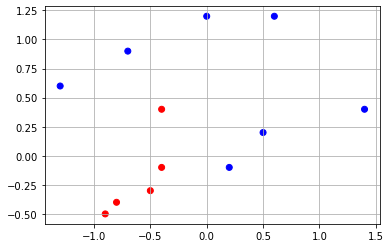

In [25]:
points, target = gen_lvq_points()

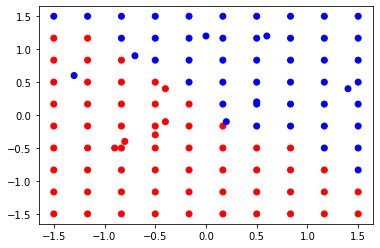

In [26]:
lvq_train(points, target)